##  Runtime Plot generation
- extracts runtime data from stored csv files and plots the runtime v. h (1/mesh_stepsize)
- also includes CG iteraction number plots

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('Utils/')
from Inverse_Util import inverse_obj
from Inverse_CG_Util import CG_FEM_solver, CG_ROM_solver, CG_difference
from ngsolve import *
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=12)  
plt.rc('ytick', labelsize=14)
%reload_ext autoreload

importing NGSolve-6.2.2203


In [3]:
def plot_func(sz, xs, ys, islog = False, title = None,
              xlab = None, ylab = None, leg = None, scatter = False, 
              c = None, bd = None):
    '''plots ys v. xs = [x1s, x2s, ...], ys = [y1, y2, ...]'''
    '''leg = [legend1, legend2, ...]'''
    plt.figure(figsize = sz)
    
    if islog:
        for i in range(len(xs)):
            xs[i] = np.log2(xs[i])
        for y in ys:
            if scatter:
                for x in xs:
                    if c != None:
                        plt.scatter(x, y, s = 50, c = c, alpha=0.5)
                    else:
                        plt.scatter(x, y, s = 50, alpha=0.5)
            else:
                for x in xs:
                    plt.plot(x, y, linewidth = 2)
                    if not bd == None:
                        plt.axis(bd)
    else:
        for y in ys:
            if scatter:
                for x in xs:
                    if c != None:
                        plt.scatter(x, y, s = 50, c = c, alpha=0.5)
                    else:
                        plt.scatter(x, y, s = 50, alpha=0.5)
            else:
                for x in xs:
                    plt.plot(x, y, linewidth = 2)
                    if not bd == None:
                        plt.axis(bd)

    plt.xlabel(xlab, fontsize = 14)
    plt.ylabel(ylab, fontsize = 14)
    plt.legend(leg, loc=0, fontsize=16)
    plt.title(title, fontsize=18)

17     2.484052
42     4.974218
67     6.916607
92    18.652886
11    39.513085
dtype: float64


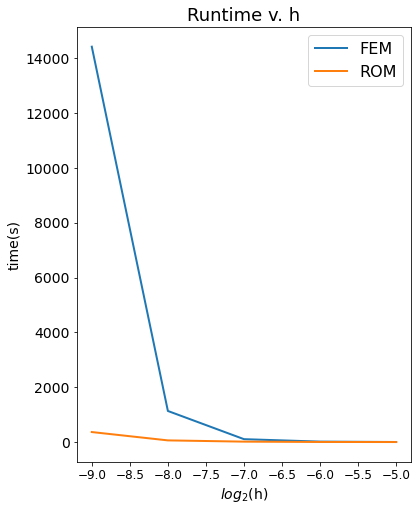

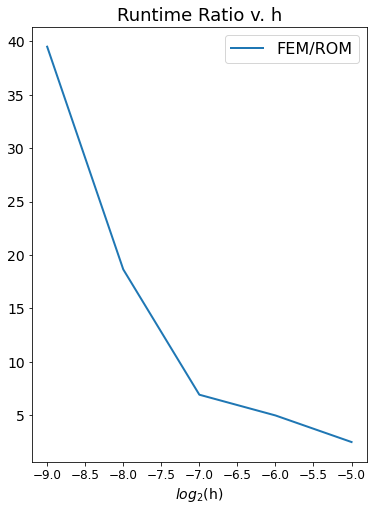

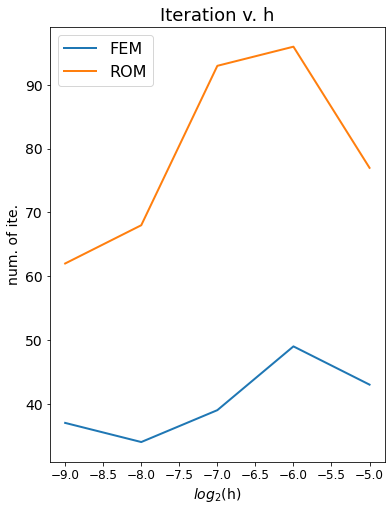

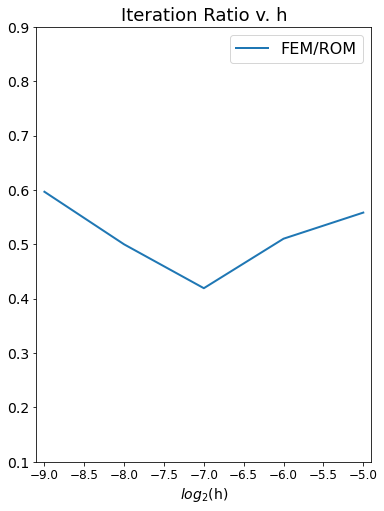

In [4]:

df1 = pd.read_csv("Data/cg_Aall_32to256_df.csv") 
df2 = pd.read_csv("Data/cg_A_512_df.csv")
df = pd.concat([df1, df2])
df
df_2 = df[df.lam == 1e-7]
df_2 = df_2[df_2.tol == 1e-8]
# print(df_2.time_f)
# print(df_2.time_r)
# print(df_2.ite_f)
# print(df_2.ite_r)
print(df_2.time_f/df_2.time_r)
text = "Runtime v. h"
plot_func([6,8], [1/np.array(df_2.h)], 
          [df_2.time_f, df_2.time_r], islog = True, title = text,
          xlab = "$log_2$(h)", ylab = "time(s)", leg = ["FEM","ROM"], scatter = False)
text = "Runtime Ratio v. h"
plot_func([6,8], [1/np.array(df_2.h)], 
          [df_2.time_f/df_2.time_r], islog = True, title = text,
          xlab = "$log_2$(h)", ylab = "", leg = ["FEM/ROM"], scatter = False)

text = "Iteration v. h"
plot_func([6,8], [1/np.array(df_2.h)], 
          [df_2.ite_f, df_2.ite_r], islog = True, title = text,
          xlab = "$log_2$(h)", ylab = "num. of ite.", leg = ["FEM","ROM"], scatter = False)
text = "Iteration Ratio v. h"
plot_func([6,8], [1/np.array(df_2.h)], 
          [df_2.ite_f/df_2.ite_r], islog = True, title = text,
          xlab = "$log_2$(h)", ylab = "", leg = ["FEM/ROM"], scatter = False, bd = [-9.1,-4.9,0.1,0.9])

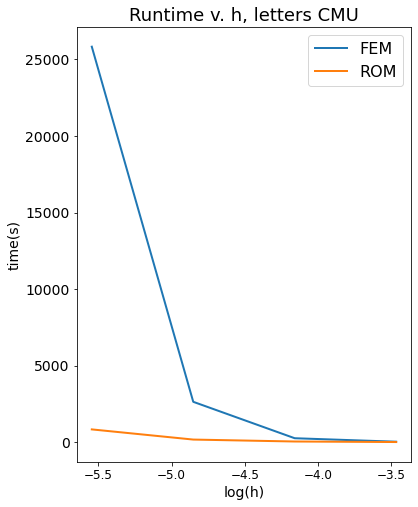

In [48]:
df = pd.read_csv("data/cg_CMU3_All_df.csv") 
df_2 = df[df.lam == 1e-7]
df_2 = df_2[df_2.tol == 1e-8]
text = "Runtime v. h, letters CMU"
plot_func([6,8], [1/np.array(df_2.h)], 
          [df_2.time_f, df_2.time_r], islog = True, title = text,
          xlab = "log(h)", ylab = "time(s)", leg = ["FEM","ROM"], scatter = False)

### Time Solver (single)

In [ ]:
h_s = [1/2**i for i in range(2,10)]
Source = sin(pi*x)*sin(pi*y)
X_fem = inverse_obj(h = h_s[0], order = 1, dim = 1, boundary = "bottom|left|right|top", 
                T = 1, dt = h_s[0], u0 = 0, source = Source, showSol = False)
X_rom = inverse_obj(h = h_s[0], order = 1, dim = 1, boundary = "bottom|left|right|top", 
                T = 1, dt = h_s[0], u0 = 0, source = Source, showSol = False)
time_femmesh = []; time_fem = []
time_rommesh = []; time_rom = []
fem_sol = []; rom_sol = []
diff = []

for k in range(len(h_s)):
    tm0 = time.time()
    X_fem.h = h_s[k]
    X_fem.dt = h_s[k]
    X_fem.get_mesh()
    tm1 = time.time()
    X_fem.solve_fem(save = True)
    
    tm2 = time.time()
    time_femmesh.append(tm1-tm0)
    time_fem.append(tm2-tm1)
    fem_sol.append(X_fem.fem_uT)
    print('fem-progress ',(k+1)/len(h_s))

for k in range(len(h_s)):
    tm10 = time.time()
    X_rom.h = h_s[k]
    X_rom.dt = h_s[k]
    X_rom.get_mesh()
    tm11 = time.time()
    X_rom.solve_rom(save = True)
    
    tm12 = time.time()
    time_rommesh.append(tm11-tm10)
    time_rom.append(tm12-tm11)
    rom_sol.append(X_rom.rom_uT)
    print('rom-progress ',(k+1)/len(h_s))

for k in range(len(h_s)):
    diff.append(np.sqrt(np.dot(rom_sol[k]-fem_sol[k], rom_sol[k]-fem_sol[k])))

In [ ]:
#mesh time compare
plot_func((10,5), h_s, time_femmesh, time_rommesh, True, 
          'log(h)', 'time(sec)', ["FEM", "ROM"])

In [ ]:
#solve time compare
plot_func((10,8), h_s, time_fem, time_rom, True, 
          'log(h)', 'time(sec)', ["FEM", "ROM"])

In [ ]:
#total time compare
plot_func((10,8), h_s, np.array(time_fem)+np.array(time_femmesh), 
          np.array(time_rom)+np.array(time_rommesh), True, 
          'log(h)', 'time(sec)', ["FEM", "ROM"])

In [ ]:
#solution difference compare
plt.figure(figsize = (10,5))
plt.scatter(np.log(h_s), diff, s = 70, c='b', marker = 'o')
plt.xlabel('log(h)',fontsize = 14)
plt.ylabel('diff',fontsize = 14)
#plt.title('Algorithm mesh size v. time',fontsize = 14)

### Time CG+solver

In [9]:
h_s = [1/2**i for i in range(2,10)]
Source = sin(pi*x)*sin(pi*y)
f0 = x

time_femmesh = []; time_fem = []
time_rommesh = []; time_rom = []
fem_sol = []; rom_sol = []
fem_ite = []; rom_ite = []
diff = []
for k in range(len(h_s)):
    tm0 = time.time()
    X_fem = inverse_obj(h = h_s[k], order = 1, dim = 1, boundary = "bottom|left|right|top", 
                T = 1, dt = h_s[k], u0 = 0, source = Source, showSol = False)
    X_fem.get_mesh()
    tm1 = time.time()
    X_fem.solve_fem(save = True)
    result, ite_n = CG_FEM_solver(X_fem, f0, lam = 1e-9, withM = True, tol2 = 1e-8, ite = True)
    tm2 = time.time()
    time_femmesh.append(tm1-tm0)
    time_fem.append(tm2-tm1)
    fem_sol.append(result)
    fem_ite.append(ite_n)
    print('fem-progress ',(k+1)/len(h_s))

for k in range(len(h_s)):
    tm0 = time.time()
    X_rom = inverse_obj(h = h_s[k], order = 1, dim = 1, boundary = "bottom|left|right|top", 
                T = 1, dt = h_s[k], u0 = 0, source = Source, showSol = False)
    X_rom.get_mesh()
    tm1 = time.time()
    X_rom.solve_rom(save = True)
    result, ite_n = CG_ROM_solver(X_rom, f0, lam = 1e-9, withM = True, tol2 = 1e-8, ite = True)
    tm2 = time.time()
    time_rommesh.append(tm1-tm0)
    time_rom.append(tm2-tm1)
    rom_sol.append(result)
    rom_ite.append(ite_n)
    print('rom-progress ',(k+1)/len(h_s))

for k in range(len(h_s)):
    diff.append(np.sqrt(np.dot(rom_sol[k]-fem_sol[k], rom_sol[k]-fem_sol[k])))


CG-stdFEM used 0.019760847091674805 sec
used 12 iterations
fem-progress  0.125

CG-stdFEM used 0.06970596313476562 sec
used 24 iterations
fem-progress  0.25

CG-stdFEM used 0.40865302085876465 sec
used 39 iterations
fem-progress  0.375

CG-stdFEM used 2.5204739570617676 sec
used 47 iterations
fem-progress  0.5

CG-stdFEM used 18.63364291191101 sec
used 47 iterations
fem-progress  0.625

CG-stdFEM used 155.0846791267395 sec
used 47 iterations
fem-progress  0.75

CG-stdFEM used 1585.1977179050446 sec
used 38 iterations
fem-progress  0.875

CG-stdFEM used 17650.87503385544 sec
used 36 iterations
fem-progress  1.0

CG-ROM used 0.03760576248168945 sec
used 16 iterations
rom-progress  0.125

CG-ROM used 0.12686991691589355 sec
used 44 iterations
rom-progress  0.25
50 5.435145976350484e-08

CG-ROM used 0.41402602195739746 sec
used 85 iterations
rom-progress  0.375
50 2.8602923994576567e-07

CG-ROM used 1.1052420139312744 sec
used 97 iterations
rom-progress  0.5
50 5.865293914631821e-07

CG-R

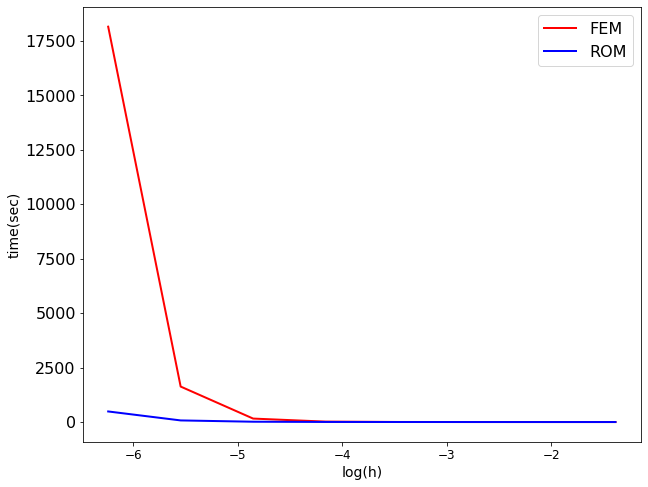

In [10]:
#solve time compare
plot_func((10,8), h_s, time_fem, time_rom, True, 
          'log(h)', 'time(sec)', ["FEM", "ROM"])

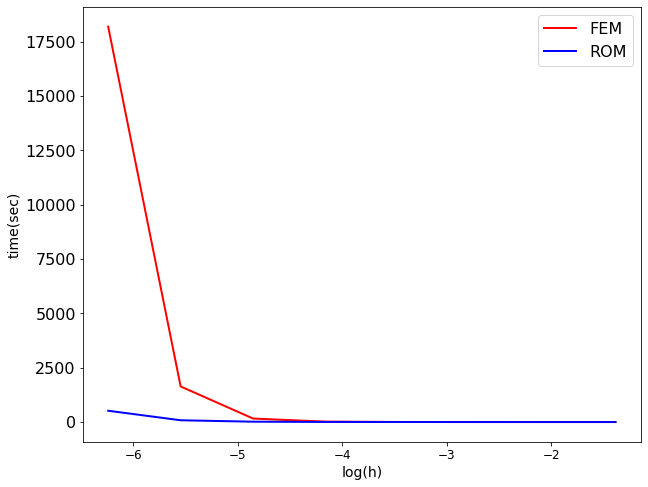

In [11]:
#total time compare
plot_func((10,8), h_s, np.array(time_fem)+np.array(time_femmesh), 
          np.array(time_rom)+np.array(time_rommesh), True, 
          'log(h)', 'time(sec)', ["FEM", "ROM"])

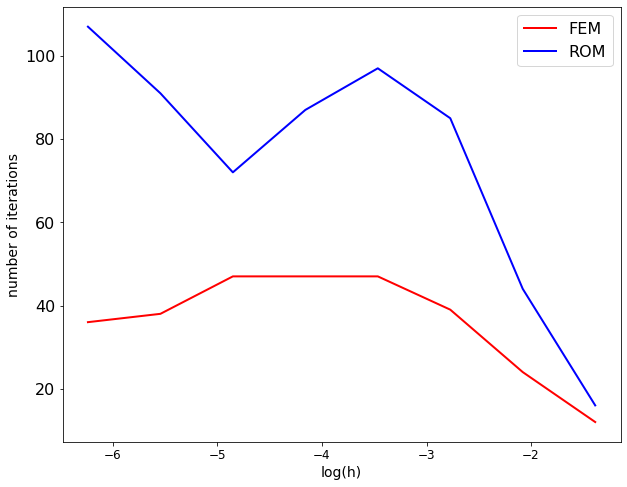

In [12]:
#iteration num compare
plot_func((10,8), h_s, fem_ite, rom_ite, True, 
          'log(h)', 'number of iterations', ["FEM", "ROM"])

Text(0, 0.5, 'diff')

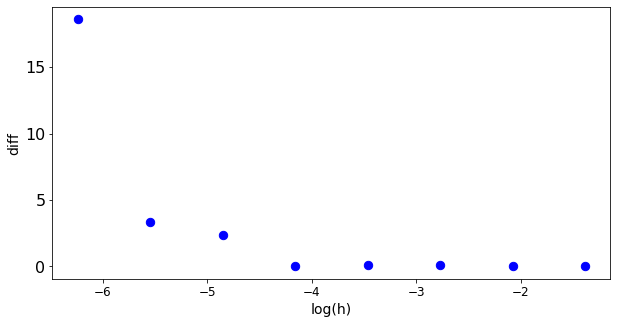

In [13]:
#solution difference compare
plt.figure(figsize = (10,5))
plt.scatter(np.log(h_s), diff, s = 70, c='b', marker = 'o')
plt.xlabel('log(h)',fontsize = 14)
plt.ylabel('diff',fontsize = 14)
#plt.title('Algorithm mesh size v. time',fontsize = 14)